# XGBoost Algorithm Demonstration (using Dask)

## Dataset used - Airlines Delay

Airline on-time statistics and delay causes

<b>Aim : To determine/predict whether a flight will be delayed based on data provided.</b>

## XGBoost Implementation on Airline Data (using Dask)

#### Import Dask and Start Client

In [1]:
import dask
from dask.distributed import Client, progress, LocalCluster
client = Client(n_workers=1)
client.restart()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 8,Total memory: 7.83 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:59243,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 7.83 GiB
Comm: tcp://127.0.0.1:59266,Total threads: 8
Dashboard: http://127.0.0.1:59267/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:59246,


#### Import Libraries 

In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
# from sklearn.metrics import accuracy_score
# from dask_ml.metrics import accuracy_score

In [3]:
%%time

# client = Client(asynchronous=True, n_workers=4, threads_per_worker=2)

import dask.dataframe as dd

# Subset of the columns to use
cols = ['ActualElapsedTime', 'CRSElapsedTime', 'Distance','AirTime','ArrDelay',
        'DepDelay', 'CRSDepTime', 'CRSArrTime', 'CarrierDelay', 'LateAircraftDelay','Origin', 'Dest','UniqueCarrier']

# Create the dataframe
df = dd.read_csv('DelayedFlights.csv', usecols=cols, storage_options={'anon': True},dtype={'Distance': 'float64','CRSArrTime': 'float64',
       'CRSDepTime': 'float64'},assume_missing=True)



# XGBoost requires a bit of RAM, we need a larger cluster
df = df.sample(frac=0.2) 

df['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)
df['CRSArrTime'] = df['CRSArrTime'].clip(upper=2399)


Wall time: 981 ms


##### Remove Missing Values

In [4]:
df = df.dropna()

In [5]:
df.head()

,CRSDepTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,CarrierDelay,LateAircraftDelay
309678,1715.0,1905.0,MQ,156.0,110.0,78.0,254.0,208.0,XNA,ORD,522.0,0.0,83.0
430011,900.0,1034.0,OH,105.0,94.0,72.0,56.0,45.0,DCA,BOS,399.0,0.0,0.0
344209,900.0,1135.0,AA,138.0,155.0,121.0,135.0,152.0,TPA,LGA,1011.0,0.0,0.0
83601,1800.0,2043.0,US,356.0,343.0,327.0,43.0,30.0,PHL,LAS,2176.0,24.0,6.0
476958,950.0,1140.0,DL,121.0,110.0,82.0,20.0,9.0,ATL,FLL,581.0,6.0,3.0


##### Dependent Column is DepDelay

In [6]:
is_delayed = (df.DepDelay.fillna(16) > 15)  # column of labels

# Remove delay information from training dataframe
del df['DepDelay']  


#### Categorize and One Hot Encode

In [7]:
df.head()

,CRSDepTime,CRSArrTime,UniqueCarrier,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,Origin,Dest,Distance,CarrierDelay,LateAircraftDelay
309678,1715.0,1905.0,MQ,156.0,110.0,78.0,254.0,XNA,ORD,522.0,0.0,83.0
430011,900.0,1034.0,OH,105.0,94.0,72.0,56.0,DCA,BOS,399.0,0.0,0.0
344209,900.0,1135.0,AA,138.0,155.0,121.0,135.0,TPA,LGA,1011.0,0.0,0.0
83601,1800.0,2043.0,US,356.0,343.0,327.0,43.0,PHL,LAS,2176.0,24.0,6.0
476958,950.0,1140.0,DL,121.0,110.0,82.0,20.0,ATL,FLL,581.0,6.0,3.0


In [8]:
%%time

# We create new indicator columns for each of the known airports and carriers. This expands our data into many boolean columns.
# categorize requires computation, and results in converting data into categorical type. The get_dummies() function is used to convert categorical variable into dummy/indicator variables. 
 
df2 = dd.get_dummies(df.categorize()).persist()




Wall time: 6.46 s


In [9]:
len(df2.columns)

628

In [10]:
df2.head()

,CRSDepTime,CRSArrTime,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,Distance,CarrierDelay,LateAircraftDelay,UniqueCarrier_MQ,...,Dest_RKS,Dest_PLN,Dest_LMT,Dest_GST,Dest_DLG,Dest_LWB,Dest_OTH,Dest_ITH,Dest_HTS,Dest_WYS
309678,1715.0,1905.0,156.0,110.0,78.0,254.0,522.0,0.0,83.0,1,...,0,0,0,0,0,0,0,0,0,0
430011,900.0,1034.0,105.0,94.0,72.0,56.0,399.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
344209,900.0,1135.0,138.0,155.0,121.0,135.0,1011.0,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0
83601,1800.0,2043.0,356.0,343.0,327.0,43.0,2176.0,24.0,6.0,0,...,0,0,0,0,0,0,0,0,0,0
476958,950.0,1140.0,121.0,110.0,82.0,20.0,581.0,6.0,3.0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
is_delayed.head()

309678     True
430011     True
344209     True
83601      True
476958    False
Name: DepDelay, dtype: bool

In [12]:
df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 12 entries, CRSDepTime to LateAircraftDelay
dtypes: object(3), float64(9)

In [13]:
X = df2
y = is_delayed

#### Split into training and testing data

We split our distributed dataframes

In [22]:
%%time
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

data_train, data_test = X.random_split([0.8, 0.2], random_state=0)
labels_train, labels_test = y.random_split([0.8, 0.2], random_state=0)

Wall time: 176 ms


#### Train data model using Dask XGBoost

##### We start up a distributed XGBoost instance, and train on this data

In [23]:
%%time
# from xgboost import XGBClassifier
import dask_xgboost as dxgb

param = {'objective': 'binary:logistic', 'nround': 1000,
          'max_depth': 16, 'eta': 0.01, 'subsample': 0.5,
          'min_child_weight': 1, 'tree_method': 'hist',
          'grow_policy': 'lossguide'}

# param = {
#     'max_depth': 3,  # the maximum depth of each tree
#     'eta': 0.3,  # the training step for each iteration
#     'objective': 'multi:softprob',  # error evaluation for multiclass training
#     'num_class': 3,
#     # 'silent': 0, 
#     'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
# num_round = 200  # the number of training iterations


# Booster Object created
bst = dxgb.train(client, param, data_train, labels_train)

Wall time: 26.5 s


In [24]:
bst

##### Compute Predictions

In [25]:
# dask-xgboost is used to predict in parallel across the cluster
predictions = dxgb.predict(client, bst, data_test).persist()
predictions

dask.array<values, shape=(nan,), dtype=float32, chunksize=(nan,), chunktype=numpy.ndarray>

In [26]:
predictions.compute()

array([0.5476279, 0.4572244, 0.5477003, ..., 0.5477003, 0.5477003,
       0.5476834], dtype=float32)

#### Evaluate and Plot ROC Curve

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
print("ROC_AUC Score : ",roc_auc_score(labels_test.compute(), predictions.compute()))

ROC_AUC Score :  0.9921234943382894


In [28]:
import matplotlib.pyplot as plt

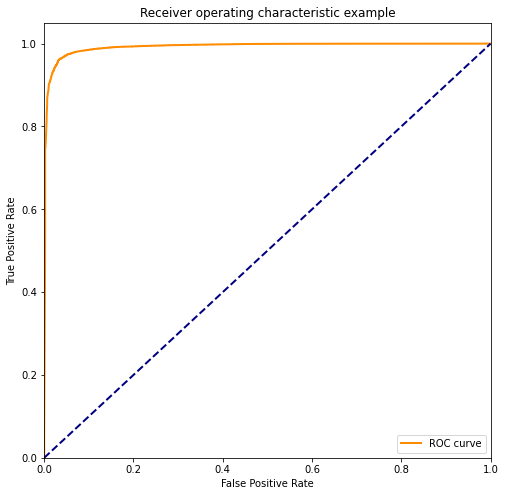

In [29]:
fpr, tpr, _ = roc_curve(labels_test.compute(), predictions.compute())
# Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

This Receiver Operating Characteristic (ROC) curve tells how well our classifier is doing. We can tell it’s doing well by how far it bends the upper-left. A perfect classifier would be in the upper-left corner, and a random classifier would follow the diagonal line.

The area under this curve is area = 0.99. This tells us the probability that our classifier will predict correctly for a randomly chosen instance.

## XGBoost Implementation on Airline Data (without using Dask)

#### Train Data on XGBoost 

In [34]:
%%time


# use DMatrix for xgboost
dtrain = xgb.DMatrix(data_train,enable_categorical=True, label=labels_train)
dtest = xgb.DMatrix(data_test,enable_categorical=True, label=labels_test)



# set xgboost params
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 3,
    'eval_metric':'mlogloss'}  # the number of classes that exist in this datset
num_round = 200  # the number of training iterations



#------------- numpy array ------------------
# training - numpy matrices
bst = xgb.train(param, dtrain, num_round)

Wall time: 9min 44s


#### Calculate Predictions

In [35]:
preds = bst.predict(dtest)

# extracting most confident predictions
best_preds = np.asarray([np.argmax(line) for line in preds])
print ("Numpy array precision:", precision_score(labels_test, best_preds, average='macro'))

Numpy array precision: 0.9646981945453083


#### Evaluate and Plot ROC Curve

In [36]:
print("ROC_AUC Score : ",roc_auc_score(labels_test, best_preds))

ROC_AUC Score :  0.9707887432786627


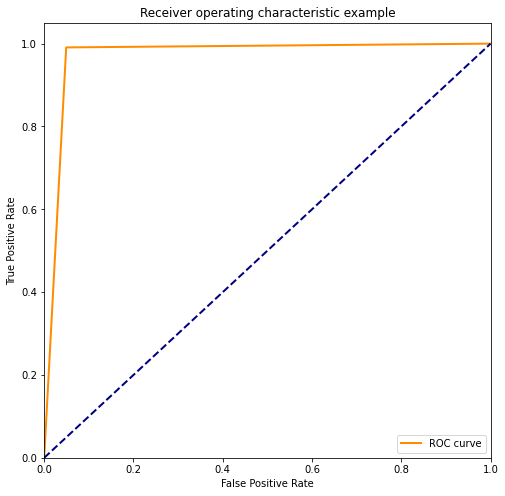

In [37]:
fpr, tpr, _ = roc_curve(labels_test, best_preds)
# Taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

This Receiver Operating Characteristic (ROC) curve tells how well our classifier is doing. We can tell it’s doing well by how far it bends the upper-left. A perfect classifier would be in the upper-left corner, and a random classifier would follow the diagonal line.

The area under this curve is area = 0.97. This tells us the probability that our classifier will predict correctly for a randomly chosen instance.